In [1]:
import json

with open('/home/aiteam/tykim/nia-3d/HybrIK/data/h36m/annotations/Sample_trainmin_train_Human36M_smpl_leaf_twist_protocol_2.json') as f:
  h36m_ann = json.load(f)

In [2]:
h36m_ann.keys()

dict_keys(['images', 'annotations'])

In [6]:
len(h36m_ann['images'])

156094

In [4]:
h36m_ann['images'][0]

{'id': 0,
 'file_name': 's_01_act_02_subact_01_ca_01/s_01_act_02_subact_01_ca_01_000001.jpg',
 'width': 1000,
 'height': 1002,
 'subject': 1,
 'action_name': 'Directions',
 'action_idx': 2,
 'subaction_idx': 1,
 'cam_idx': 1,
 'frame_idx': 0,
 'cam_param': {'R': [[-0.9153617321513369,
    0.40180836633680234,
    0.02574754463350265],
   [0.051548117060134555, 0.1803735689384521, -0.9822464900705729],
   [-0.399319034032262, -0.8977836111057917, -0.185819527201491]],
  't': [1841.10702774543, 4955.28462344526, 1563.4453958977],
  'f': [1145.04940458804, 1143.78109572365],
  'c': [512.541504956548, 515.4514869776]}}

In [22]:
h36m_ann['annotations'][0]

{'thetas': [0.6043401228135528,
  0.5169300675655754,
  -2.931242244830518,
  0.23788822077468236,
  0.07521908917945466,
  -0.12391551378285227,
  -0.17162622477423983,
  0.05077439883136112,
  -0.13418103533465325,
  0.16911627084560066,
  -0.02552452254288435,
  -0.035518216463865125,
  -0.10116690386174097,
  -0.16153688956281378,
  -0.12067669108576662,
  0.6041423465307574,
  0.08599049561711458,
  -0.04968774525743606,
  0.06536734925585869,
  0.007421430289085677,
  -0.008320298270203627,
  -0.20562794036385046,
  0.14405818776620255,
  0.20857867046544853,
  -0.2809085357352574,
  -0.29611146989388476,
  0.05583065714397889,
  0.005229801357331548,
  -0.032816127602637725,
  -0.042904887925862514,
  0.0021556113993940265,
  0.26397659621819186,
  -0.1273582739490245,
  0.006065624551278396,
  0.24889865380369613,
  -0.08139202571227583,
  -0.13947150015139137,
  0.10363196145069944,
  0.11544891007360923,
  -0.0010942539430904086,
  -0.18615081376471654,
  -0.5740409002238056,

In [17]:
h36m_ann['annotations'][0].keys()

dict_keys(['thetas', 'betas', 'bbox', 'area', 'iscrowd', 'category_id', 'image_id', 'id', 'root_coord', 'h36m_joints', 'smpl_joints', 'angle_twist'])

In [5]:
len(h36m_ann['annotations'][0]['h36m_joints'])

51

In [1]:
h36m_ann['annotations'][0]['h36m_joints']

NameError: name 'h36m_ann' is not defined

In [7]:
import numpy as np


j_reg = np.load('/home/aiteam/tykim/HybrIK/model_files/J_regressor_h36m.npy')

In [8]:
j_reg.shape

(17, 6890)

In [9]:
init_shape = np.load('/home/aiteam/tykim/HybrIK/model_files/h36m_mean_beta.npy')

In [10]:
init_shape.shape

(10,)

In [11]:
init_shape

array([-1.99160167e-01,  5.86332557e-01,  4.33076857e-01,  7.36459755e-01,
        3.33868332e-01,  1.04054349e-01, -5.02988660e-01,  9.17672318e-04,
        1.27455407e+00,  4.92503261e-01])

In [2]:
import torch
from hybrik.models.layers.smpl.lbs import blend_shapes, vertices2joints, quat_to_rotmat, batch_rodrigues, batch_rigid_transform

/home/aiteam/miniconda3/envs/hybrik/lib/python3.7/site-packages/tqdm-4.64.0-py3.7.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def rotmat_to_aa(rotmat):
    batch_size = rotmat.shape[0]

    r11 = rotmat[:, 0, 0]
    r22 = rotmat[:, 1, 1]
    r33 = rotmat[:, 2, 2]

    r12 = rotmat[:, 0, 1]
    r21 = rotmat[:, 1, 0]
    r13 = rotmat[:, 0, 2]
    r31 = rotmat[:, 2, 0]
    r23 = rotmat[:, 1, 2]
    r32 = rotmat[:, 2, 1]
    
    angle = torch.acos((r11 + r22 + r33 - 1) / 2).unsqueeze(dim=1)
    '''
    if -1e-6 < (r11 + r22 + r33 - 1) / 2 + 1 < 1e-6:
        angle = torch.acos(-torch.ones_like(r11)).unsqueeze(dim=1)
    else:
        angle = torch.acos((r11 + r22 + r33 - 1) / 2).unsqueeze(dim=1)
    '''
    axis = torch.zeros((batch_size, 3))
    axis[:, 0] = r32 - r23
    axis[:, 1] = r13 - r31
    axis[:, 2] = r21 - r12
    axis = axis / (2 * torch.sin(angle) + 1e-8)

    aa = axis * angle
    return aa, axis, angle

In [4]:
def get_twist(rot_mats, joints, parents):
    joints = torch.unsqueeze(joints, dim=-1)
    rel_joints = joints.clone()
    rel_joints[:, 1:] -= joints[:, parents[1:]].clone()

    # modified by xuchao
    childs = -torch.ones((parents.shape[0]), dtype=parents.dtype, device=parents.device)
    for i in range(1, parents.shape[0]):
        childs[parents[i]] = i

    dtype = rot_mats.dtype
    batch_size = rot_mats.shape[0]
    device = rot_mats.device

    angle_twist = []
    error = False
    for i in range(1, parents.shape[0]):
        # modified by xuchao
        if childs[i] < 0:
            angle_twist.append(torch.zeros((batch_size, 1), dtype=rot_mats.dtype, device=rot_mats.device))
            continue

        u = rel_joints[:, childs[i]]
        rot = rot_mats[:, i]

        v = torch.matmul(rot, u)

        u_norm = torch.norm(u, dim=1, keepdim=True)
        v_norm = torch.norm(v, dim=1, keepdim=True)

        axis = torch.cross(u, v, dim=1)
        axis_norm = torch.norm(axis, dim=1, keepdim=True)

        # (B, 1, 1)
        cos = torch.sum(u * v, dim=1, keepdim=True) / (u_norm * v_norm + 1e-8)
        sin = axis_norm / (u_norm * v_norm + 1e-8)

        # (B, 3, 1)
        axis = axis / (axis_norm + 1e-8)

        # Convert location revolve to rot_mat by rodrigues
        # (B, 1, 1)
        rx, ry, rz = torch.split(axis, 1, dim=1)
        zeros = torch.zeros((batch_size, 1, 1), dtype=dtype, device=device)

        K = torch.cat([zeros, -rz, ry, rz, zeros, -rx, -ry, rx, zeros], dim=1) \
            .view((batch_size, 3, 3))
        ident = torch.eye(3, dtype=dtype, device=device).unsqueeze(dim=0)
        rot_mat_pivot = ident + sin * K + (1 - cos) * torch.bmm(K, K)

        rot_mat_twist = torch.matmul(rot_mat_pivot.transpose(1, 2), rot)
        _, axis, angle = rotmat_to_aa(rot_mat_twist)

        axis = axis / torch.norm(axis, dim=1, keepdim=True)
        spin_axis = u / u_norm
        spin_axis = spin_axis.squeeze(-1)

        pos = torch.norm(spin_axis - axis, dim=1)
        neg = torch.norm(spin_axis + axis, dim=1)
        if float(neg) < float(pos):
            try:
                assert float(pos) > 1.9, (pos, neg)
                angle_twist.append(-1 * angle)
            except AssertionError:
                angle_twist.append(torch.ones_like(angle) * -999)
                error = True
        else:
            try:
                assert float(neg) > 1.9, (pos, neg, axis, angle, rot_mat_twist)
                angle_twist.append(angle)
            except AssertionError:
                angle_twist.append(torch.ones_like(angle) * -999)
                error = True

    angle_twist = torch.stack(angle_twist, dim=1)
    if error:
        angle_twist[:] = -999

    return angle_twist

In [5]:
import numpy as np
import torch

def to_tensor(array, dtype=torch.float32):
    if 'torch.tensor' not in str(type(array)):
        return torch.tensor(array, dtype=dtype)

def to_np(array, dtype=np.float32):
    if 'scipy.sparse' in str(type(array)):
        array = array.todense()
    return np.array(array, dtype=dtype)


In [6]:
dtype=torch.float32
betas = to_tensor(to_np(h36m_ann['annotations'][0]['betas']), dtype=dtype)
thetas = to_tensor(to_np(h36m_ann['annotations'][0]['thetas']), dtype=dtype)

In [7]:
try:
    import cPickle as pk
except ImportError:
    import pickle as pk

class Struct(object):
    def __init__(self, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)

model_path = './model_files/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl'
with open(model_path, 'rb') as smpl_file:
  smpl_data = Struct(**pk.load(smpl_file, encoding='latin1'))


In [12]:
dtype=torch.float32

JOINT_NAMES = [
        'pelvis', 'left_hip', 'right_hip',      # 2
        'spine1', 'left_knee', 'right_knee',    # 5
        'spine2', 'left_ankle', 'right_ankle',  # 8
        'spine3', 'left_foot', 'right_foot',    # 11
        'neck', 'left_collar', 'right_collar',  # 14
        'jaw',                                  # 15
        'left_shoulder', 'right_shoulder',      # 17
        'left_elbow', 'right_elbow',            # 19
        'left_wrist', 'right_wrist',            # 21
        'left_thumb', 'right_thumb',            # 23
        'head', 'left_middle', 'right_middle',  # 26
        'left_bigtoe', 'right_bigtoe'           # 28
    ]
NUM_JOINTS = 23

num_joints = 24

parents = torch.zeros(len(JOINT_NAMES), dtype=torch.long)
parents[:(NUM_JOINTS + 1)] = to_tensor(to_np(smpl_data.kintree_table[0])).long()
parents[0] = -1
# extend kinematic tree
parents[24] = 15
parents[25] = 22
parents[26] = 23
parents[27] = 10
parents[28] = 11
if parents.shape[0] > num_joints:
    parents = parents[:24]

In [8]:
lbs_weights = to_tensor(to_np(smpl_data.weights), dtype=dtype) # (6890, 23 + 1)
shapedirs = to_tensor(to_np(smpl_data.shapedirs), dtype=dtype) # (6890, 3, 10)
v_template = to_tensor(to_np(smpl_data.v_template), dtype=dtype) # (6890, 3)
J_regressor = to_tensor(to_np(smpl_data.J_regressor), dtype=dtype) # (24, 6890)
betas=betas.unsqueeze(0)
pose = thetas.unsqueeze(0)
num_pose_basis = smpl_data.posedirs.shape[-1]
posedirs = to_tensor(np.reshape(smpl_data.posedirs, [-1, num_pose_basis]).T)

In [9]:
batch_size = max(betas.shape[0], pose.shape[0])
device = betas.device

# Add shape contribution
v_shaped = v_template + blend_shapes(betas, shapedirs)

In [10]:
# Get the joints
# NxJx3 array
J = vertices2joints(J_regressor, v_shaped)

In [13]:
# 3. Add pose blend shapes
# N x J x 3 x 3
ident = torch.eye(3, dtype=dtype, device=device)
if pose.numel() == batch_size * 24 * 4:
    rot_mats = quat_to_rotmat(pose.reshape(batch_size * 24, 4)).reshape(batch_size, 24, 3, 3)
else:
    rot_mats = batch_rodrigues(
        pose.view(-1, 3), dtype=dtype).view([batch_size, -1, 3, 3])

pose_feature = (rot_mats[:, 1:, :, :] - ident).view([batch_size, -1])
# (N x P) x (P, V * 3) -> N x V x 3
pose_offsets = torch.matmul(pose_feature, posedirs) \
    .view(batch_size, -1, 3)


v_posed = pose_offsets + v_shaped
# 4. Get the global joint location
J_transformed, A = batch_rigid_transform(rot_mats, J.clone(), parents, dtype=dtype)

twist_angle = get_twist(rot_mats, J.clone(), parents)

In [14]:
twist_angle.shape

torch.Size([1, 23, 1])

In [21]:
len(h36m_ann['annotations'][0]['angle_twist']['cos'])

23

In [20]:
h36m_ann['annotations'][0]['angle_twist']

{'angle': [-0.05321325361728668,
  -0.031361717730760574,
  -0.019494902342557907,
  0.1769900918006897,
  -0.05825100094079971,
  0.006137609947472811,
  0.09400433301925659,
  0.20302818715572357,
  -0.01674475520849228,
  0.0,
  0.0,
  0.1449068784713745,
  -0.018676631152629852,
  0.01197043340653181,
  0.0,
  0.06573420017957687,
  -0.24674782156944275,
  0.09106678515672684,
  0.17114700376987457,
  0.10973480343818665,
  -0.14323297142982483,
  0.0,
  0.0],
 'cos': [0.998584508895874,
  0.999508261680603,
  0.999809980392456,
  0.9843780994415283,
  0.9983038902282715,
  0.999981164932251,
  0.9955848455429077,
  0.9794604778289795,
  0.9998598098754883,
  1.0,
  1.0,
  0.9895193576812744,
  0.9998255968093872,
  0.99992835521698,
  1.0,
  0.9978402853012085,
  0.9697118997573853,
  0.9958562850952148,
  0.9853900671005249,
  0.9939851760864258,
  0.9897596836090088,
  1.0,
  1.0],
 'sin': [-0.05318814516067505,
  -0.0313565768301487,
  -0.019493667408823967,
  0.176067486405372

In [19]:
h36m_ann['annotations'][0].keys()

dict_keys(['thetas', 'betas', 'bbox', 'area', 'iscrowd', 'category_id', 'image_id', 'id', 'root_coord', 'h36m_joints', 'smpl_joints', 'angle_twist'])

In [21]:
h36m_ann['annotations'][0]['thetas']

[0.6043401228135528,
 0.5169300675655754,
 -2.931242244830518,
 0.23788822077468236,
 0.07521908917945466,
 -0.12391551378285227,
 -0.17162622477423983,
 0.05077439883136112,
 -0.13418103533465325,
 0.16911627084560066,
 -0.02552452254288435,
 -0.035518216463865125,
 -0.10116690386174097,
 -0.16153688956281378,
 -0.12067669108576662,
 0.6041423465307574,
 0.08599049561711458,
 -0.04968774525743606,
 0.06536734925585869,
 0.007421430289085677,
 -0.008320298270203627,
 -0.20562794036385046,
 0.14405818776620255,
 0.20857867046544853,
 -0.2809085357352574,
 -0.29611146989388476,
 0.05583065714397889,
 0.005229801357331548,
 -0.032816127602637725,
 -0.042904887925862514,
 0.0021556113993940265,
 0.26397659621819186,
 -0.1273582739490245,
 0.006065624551278396,
 0.24889865380369613,
 -0.08139202571227583,
 -0.13947150015139137,
 0.10363196145069944,
 0.11544891007360923,
 -0.0010942539430904086,
 -0.18615081376471654,
 -0.5740409002238056,
 0.01454053292526146,
 0.2652333609138684,
 0.59536

In [23]:
try:
    import cPickle as pk
except ImportError:
    import pickle as pk

class Struct(object):
    def __init__(self, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)

model_path = './model_files/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl'
with open(model_path, 'rb') as smpl_file:
  smpl_data = Struct(**pk.load(smpl_file, encoding='latin1'))

In [29]:
def to_tensor(array, dtype=torch.float32):
    if 'torch.tensor' not in str(type(array)):
        return torch.tensor(array, dtype=dtype)

def to_np(array, dtype=np.float32):
    if 'scipy.sparse' in str(type(array)):
        array = array.todense()
    return np.array(array, dtype=dtype)

In [30]:
num_pose_basis = smpl_data.posedirs.shape[-1]
posedirs = np.reshape(smpl_data.posedirs, [-1, num_pose_basis]).T

In [31]:
posedirs.shape

(207, 20670)

In [35]:
dtype=torch.float32

JOINT_NAMES = [
        'pelvis', 'left_hip', 'right_hip',      # 2
        'spine1', 'left_knee', 'right_knee',    # 5
        'spine2', 'left_ankle', 'right_ankle',  # 8
        'spine3', 'left_foot', 'right_foot',    # 11
        'neck', 'left_collar', 'right_collar',  # 14
        'jaw',                                  # 15
        'left_shoulder', 'right_shoulder',      # 17
        'left_elbow', 'right_elbow',            # 19
        'left_wrist', 'right_wrist',            # 21
        'left_thumb', 'right_thumb',            # 23
        'head', 'left_middle', 'right_middle',  # 26
        'left_bigtoe', 'right_bigtoe'           # 28
    ]
NUM_JOINTS = 23

num_joints = 24

parents = torch.zeros(len(JOINT_NAMES), dtype=torch.long)
parents[:(NUM_JOINTS + 1)] = to_tensor(to_np(smpl_data.kintree_table[0])).long()
parents[0] = -1
# extend kinematic tree
parents[24] = 15
parents[25] = 22
parents[26] = 23
parents[27] = 10
parents[28] = 11
if parents.shape[0] > num_joints:
    parents = parents[:24]

lbs_weights = to_tensor(to_np(smpl_data.weights), dtype=dtype) # (6890, 23 + 1)
shapedirs = to_tensor(to_np(smpl_data.shapedirs), dtype=dtype) # (6890, 3, 10)
v_template = to_tensor(to_np(smpl_data.v_template), dtype=dtype) # (6890, 3)
J_regressor = to_tensor(to_np(smpl_data.J_regressor), dtype=dtype) # (24, 6890)

In [36]:
lbs_weights.shape

('lbs_weights',
                             to_tensor(to_np(self.smpl_data.weights), dtype=dtype))

torch.Size([6890, 24])

In [42]:
from hybrik.models.layers.smpl.SMPL import SMPL_layer
h36m_jregressor = np.load('./model_files/J_regressor_h36m.npy')
smpl_layer = SMPL_layer(model_path='./model_files/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl', h36m_jregressor=h36m_jregressor, num_joints=24)

In [41]:
smpl_layer.v_template.shape

torch.Size([6890, 3])

In [47]:
betas = to_tensor(to_np(h36m_ann['annotations'][0]['betas']), dtype=dtype)

In [50]:
thetas = to_tensor(to_np(h36m_ann['annotations'][0]['thetas']), dtype=dtype)

In [61]:
type(h36m_jregressor)

numpy.ndarray

In [62]:
lbs(betas=betas.unsqueeze(0),
    pose = thetas.unsqueeze(0),
    v_template = smpl_layer.v_template,
    shapedirs = smpl_layer.shapedirs, 
    posedirs = smpl_layer.posedirs, 
    J_regressor = smpl_layer.J_regressor,
    J_regressor_h36m=smpl_layer.J_regressor_h36m,
    parents = smpl_layer.parents, 
    lbs_weights = smpl_layer.lbs_weights)

(tensor([[[-0.0274, -0.9318, -0.0531],
          [-0.0254, -0.9202, -0.0415],
          [-0.0321, -0.9135, -0.0524],
          ...,
          [ 0.1096, -0.8644, -0.0799],
          [ 0.1094, -0.8665, -0.0789],
          [ 0.1108, -0.8652, -0.0754]]]),
 tensor([[[-0.0025, -0.2230,  0.0277],
          [-0.0751, -0.1389,  0.0209],
          [ 0.0433, -0.1363,  0.0764],
          [ 0.0251, -0.3130, -0.0216],
          [-0.0869,  0.2230,  0.0582],
          [ 0.0391,  0.1814,  0.2728],
          [ 0.0310, -0.4457, -0.0470],
          [-0.0178,  0.5974,  0.1331],
          [ 0.1178,  0.5599,  0.2323],
          [ 0.0216, -0.4999, -0.0305],
          [-0.0942,  0.6002,  0.2367],
          [ 0.1157,  0.5755,  0.3591],
          [ 0.0437, -0.7097, -0.1048],
          [-0.0369, -0.6122, -0.1064],
          [ 0.1097, -0.6157, -0.0580],
          [ 0.0283, -0.7879, -0.0758],
          [-0.1243, -0.5867, -0.1244],
          [ 0.1900, -0.5967, -0.0100],
          [-0.1959, -0.3604, -0.0391],
       

In [63]:
h36m_ann['annotations'][0]['angle_twist']

{'angle': [-0.05321325361728668,
  -0.031361717730760574,
  -0.019494902342557907,
  0.1769900918006897,
  -0.05825100094079971,
  0.006137609947472811,
  0.09400433301925659,
  0.20302818715572357,
  -0.01674475520849228,
  0.0,
  0.0,
  0.1449068784713745,
  -0.018676631152629852,
  0.01197043340653181,
  0.0,
  0.06573420017957687,
  -0.24674782156944275,
  0.09106678515672684,
  0.17114700376987457,
  0.10973480343818665,
  -0.14323297142982483,
  0.0,
  0.0],
 'cos': [0.998584508895874,
  0.999508261680603,
  0.999809980392456,
  0.9843780994415283,
  0.9983038902282715,
  0.999981164932251,
  0.9955848455429077,
  0.9794604778289795,
  0.9998598098754883,
  1.0,
  1.0,
  0.9895193576812744,
  0.9998255968093872,
  0.99992835521698,
  1.0,
  0.9978402853012085,
  0.9697118997573853,
  0.9958562850952148,
  0.9853900671005249,
  0.9939851760864258,
  0.9897596836090088,
  1.0,
  1.0],
 'sin': [-0.05318814516067505,
  -0.0313565768301487,
  -0.019493667408823967,
  0.176067486405372

In [64]:
v_shaped = smpl_layer.v_template + blend_shapes(betas.unsqueeze(0), smpl_layer.shapedirs)

In [65]:
v_shaped.shape

torch.Size([1, 6890, 3])

In [66]:
J = vertices2joints(smpl_layer.J_regressor, v_shaped)

In [67]:
J.shape

torch.Size([1, 24, 3])

In [ ]:
lbs(betas=betas.unsqueeze(0),
    pose = thetas.unsqueeze(0),
    v_template = smpl_layer.v_template,
    shapedirs = smpl_layer.shapedirs, 
    posedirs = smpl_layer.posedirs, 
    J_regressor = smpl_layer.J_regressor,
    J_regressor_h36m=smpl_layer.J_regressor_h36m,
    parents = smpl_layer.parents, 
    lbs_weights = smpl_layer.lbs_weights)

In [59]:
def lbs(betas, pose, v_template, shapedirs, posedirs, J_regressor, J_regressor_h36m, parents,
        lbs_weights, pose2rot=True, dtype=torch.float32):
    ''' Performs Linear Blend Skinning with the given shape and pose parameters

        Parameters
        ----------
        betas : torch.tensor BxNB
            The tensor of shape parameters
        pose : torch.tensor Bx(J + 1) * 3
            The pose parameters in axis-angle format
        v_template torch.tensor BxVx3
            The template mesh that will be deformed
        shapedirs : torch.tensor 1xNB
            The tensor of PCA shape displacements
        posedirs : torch.tensor Px(V * 3)
            The pose PCA coefficients
        J_regressor : torch.tensor JxV
            The regressor array that is used to calculate the joints from
            the position of the vertices
        parents: torch.tensor J
            The array that describes the kinematic tree for the model
        lbs_weights: torch.tensor N x V x (J + 1)
            The linear blend skinning weights that represent how much the
            rotation matrix of each part affects each vertex
        pose2rot: bool, optional
            Flag on whether to convert the input pose tensor to rotation
            matrices. The default value is True. If False, then the pose tensor
            should already contain rotation matrices and have a size of
            Bx(J + 1)x9
        dtype: torch.dtype, optional

        Returns
        -------
        verts: torch.tensor BxVx3
            The vertices of the mesh after applying the shape and pose
            displacements.
        joints: torch.tensor BxJx3
            The joints of the model
        rot_mats: torch.tensor BxJx3x3
            The rotation matrics of each joints
    '''
    batch_size = max(betas.shape[0], pose.shape[0])
    device = betas.device

    # Add shape contribution
    v_shaped = v_template + blend_shapes(betas, shapedirs)

    # Get the joints
    # NxJx3 array
    J = vertices2joints(J_regressor, v_shaped)

    # 3. Add pose blend shapes
    # N x J x 3 x 3
    ident = torch.eye(3, dtype=dtype, device=device)
    if pose2rot:
        if pose.numel() == batch_size * 24 * 4:
            rot_mats = quat_to_rotmat(pose.reshape(batch_size * 24, 4)).reshape(batch_size, 24, 3, 3)
        else:
            rot_mats = batch_rodrigues(
                pose.view(-1, 3), dtype=dtype).view([batch_size, -1, 3, 3])

        pose_feature = (rot_mats[:, 1:, :, :] - ident).view([batch_size, -1])
        # (N x P) x (P, V * 3) -> N x V x 3
        pose_offsets = torch.matmul(pose_feature, posedirs) \
            .view(batch_size, -1, 3)
    else:
        pose_feature = pose[:, 1:].view(batch_size, -1, 3, 3) - ident
        rot_mats = pose.view(batch_size, -1, 3, 3)

        pose_offsets = torch.matmul(pose_feature.view(batch_size, -1),
                                    posedirs).view(batch_size, -1, 3)

    v_posed = pose_offsets + v_shaped
    # 4. Get the global joint location
    J_transformed, A = batch_rigid_transform(rot_mats, J.clone(), parents, dtype=dtype)

    twist_angle = get_twist(rot_mats, J.clone(), parents)

    # 5. Do skinning:
    # W is N x V x (J + 1)
    W = lbs_weights.unsqueeze(dim=0).expand([batch_size, -1, -1])
    # (N x V x (J + 1)) x (N x (J + 1) x 16)
    num_joints = J_regressor.shape[0]
    T = torch.matmul(W, A.view(batch_size, num_joints, 16)) \
        .view(batch_size, -1, 4, 4)

    homogen_coord = torch.ones([batch_size, v_posed.shape[1], 1],
                               dtype=dtype, device=device)
    v_posed_homo = torch.cat([v_posed, homogen_coord], dim=2)
    v_homo = torch.matmul(T, torch.unsqueeze(v_posed_homo, dim=-1))

    verts = v_homo[:, :, :3, 0]

    J_from_verts = vertices2joints(J_regressor_h36m, verts)

    return verts, J_transformed, rot_mats, J_from_verts, twist_angle

In [17]:
import json
with open('/home/aiteam/tykim/HybrIK/data/coco/annotations/person_keypoints_train2017.json') as f:
  coco_ann = json.load(f)

In [18]:
coco_ann.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [22]:
coco_ann['annotations'][36].keys()

dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])

In [23]:
for idx, i in enumerate(coco_ann['annotations']):
  if i['image_id'] == 36:
    print(idx)

116259


In [26]:
coco_ann['annotations'][116259]['keypoints']

[250,
 244,
 2,
 265,
 223,
 2,
 235,
 235,
 2,
 309,
 227,
 2,
 235,
 253,
 2,
 355,
 337,
 2,
 215,
 342,
 2,
 407,
 494,
 2,
 213,
 520,
 2,
 445,
 617,
 2,
 244,
 447,
 2,
 338,
 603,
 2,
 267,
 608,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [50]:
import numpy as np

In [53]:
joints_3d = np.zeros((17, 3, 2), dtype=np.float32)
for i in range(17):
  joints_3d[i, 0, 0] = coco_ann['annotations'][1]['keypoints'][i*3 + 0]
  joints_3d[i, 1, 0] = coco_ann['annotations'][1]['keypoints'][i * 3 + 1]
  visible = min(1, coco_ann['annotations'][1]['keypoints'][i * 3 + 2])
  joints_3d[i, :2, 1] = visible

In [54]:
joints_3d 

array([[[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[618.,   1.],
        [224.,   1.],
        [  0.,   0.]],

       [[431.,   1.],
        [250.,   1.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]],

       [[  0.,   0.],
        [  0.,   0.],
    

In [1]:
from hybrik.datasets.mscoco import Mscoco

/home/aiteam/miniconda3/envs/hybrik/lib/python3.7/site-packages/tqdm-4.64.0-py3.7.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import yaml
from easydict import EasyDict as edict


def update_config(config_file):
    with open(config_file) as f:
        config = edict(yaml.load(f, Loader=yaml.FullLoader))
        return config

In [3]:
cfg = update_config('/home/aiteam/tykim/HybrIK/configs/256x192_adam_lr1e-3-res34_smpl_3d_cam_2x_mix.yaml')

In [4]:
db1 = Mscoco(cfg=cfg,
              ann_file=f'/home/aiteam/tykim/HybrIK/data/coco/annotations/person_keypoints_train2017.json',
              train=True)

loading annotations into memory...
Done (t=6.17s)
creating index...
index created!


In [6]:
img, target, img_id, bbox = db1[0]

In [7]:
img.shape

torch.Size([3, 256, 256])

In [10]:
target

{'type': '2d_data',
 'target': tensor([-0.1615, -0.2706, -0.1369, -0.3125, -0.1911, -0.2849, -0.0538, -0.3126,
         -0.1880, -0.2512,  0.0512, -0.1142, -0.2103, -0.0810,  0.1755,  0.1711,
         -0.1836,  0.2530,  0.2677,  0.3951, -0.1380,  0.1109,  0.0648,  0.3872,
         -0.0674,  0.4087, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000]),
 'target_weight': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'trans_inv': tensor([[  2.0670,  -0.1885,  81.9305],
         [  0.1885,   2.0670, 106.2793]]),
 'intrinsic_param': tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
 'joint_root': tensor([0., 0., 0.]),
 'depth_factor': tensor([2000.])}

In [11]:
img_id

36

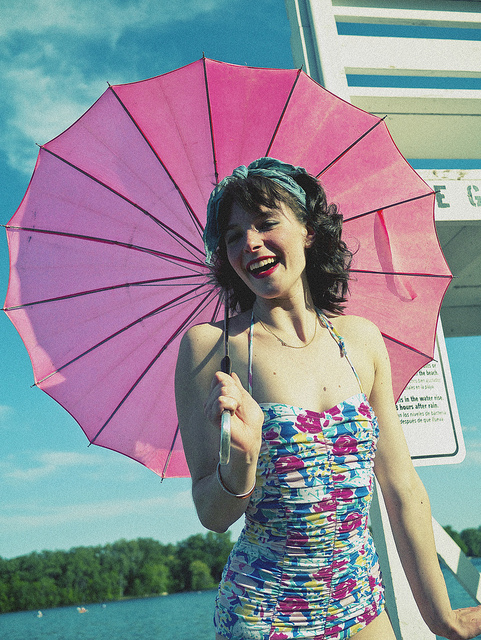

In [15]:
from PIL import Image
Image.open('/home/aiteam/tykim/HybrIK/data/coco/train2017/000000000036.jpg')

In [27]:
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import multiprocessing
import json
from PIL import Image

'''
FIXED PARAMETERS
'''

#DIMENSIONS OF RESIZED IMAGE (INPUT FOR THE MODEL)
IMG_WIDTH = 192
IMG_HEIGHT = 256

#PARAMETERS OF THE KEYPOINTS OF THE DATASET
N_DIM = 3 #x,y,visibility
N_KEYPOINTS = 17 #it is set later in the code just in case
K_NAMES = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'] #it is set later in the code just in case


def plot_keypoints(draw_non_visible,keypoints,k_vis,ax): #draw_non_visible -> option to draw (1) or not (0) keypoints that are in the dataset but not visible in the image (occlusions)
    for j in range(len(K_NAMES)):
        n = K_NAMES[j]
        x = keypoints[j,0]
        y = keypoints[j,1]

        if k_vis[j] > 0 and (draw_non_visible or (draw_non_visible == 0 and k_vis[j] == 2)):
          ax.scatter(x, y, 250)
          ax.text(x+5, y+5, n, fontsize=18, bbox=dict(facecolor='r', alpha=0.5), color='w')
          
def display_images_keypoints(draw_non_visible,og_img,bbox,res_img,keypoints,k_vis):
    #display original image with bounding box and resized image with keypoints
    bbox_x,bbox_y,bbox_w,bbox_h = bbox
    fig = plt.figure(1,figsize=(20,20))
    ax1 = fig.add_subplot(121)  # left side
    ax1.imshow(og_img)
    ax1.add_patch(Rectangle((bbox_x, bbox_y), bbox_w, bbox_h, alpha=0.3, facecolor="blue", edgecolor="red", hatch='x'))

    ax2 = fig.add_subplot(122)  # right side
    ax2.imshow(res_img)
    ax2 = plot_keypoints(draw_non_visible,keypoints,k_vis,ax2)
    plt.show()

In [31]:
def check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img):
    #attributes of the bounding box and original image
    bbox_x, bbox_y, bbox_w, bbox_h = bbox
    img_w, img_h = og_img.size
    
    #calculate min and max values of x and y positions of the keypoints
    x_min = 99999
    x_max = -1
    y_min = 99999
    y_max = -1
    for i in range(len(keypoints)):
        if k_vis[i] > 0:
            x_temp = keypoints[i][0]
            y_temp = keypoints[i][1]
            if x_temp < x_min: x_min = x_temp
            if x_temp > x_max: x_max = x_temp
            if y_temp < y_min: y_min = y_temp
            if y_temp > y_max: y_max = y_temp
    x_min = x_min-10
    x_max = x_max+10
    y_min = y_min-10
    y_max = y_max+10
        
    if x_min < bbox_x:
        if x_min < 0: x_min = 0
    else:
        x_min = bbox_x
    
    if x_max > bbox_x+bbox_w:
        if x_max > img_w: x_max = img_w
    else:
        x_max = bbox_x+bbox_w
        
    if y_min < bbox_y:
        if y_min < 0: y_min = 0
    else:
        y_min = bbox_y
        
    if y_max > bbox_y+bbox_h:
        if y_max > img_h: y_max = img_h
    else:
        y_max = bbox_y+bbox_h
        
    bbox = [x_min,y_min,x_max-x_min,y_max-y_min]
    return bbox
    

In [33]:
def get_sample_att(sample_n): #torval -> 0 if training and 1 if validation dataset
    sample = coco_ann['annotations'][sample_n]
    img_id = str(sample['image_id'])
    k_list = sample['keypoints']
    bbox = sample['bbox']
    is_crowd = sample['iscrowd']

    #the keypoints in each sample are indicated in a list as: x1, y1, v1, x2, y2, v2, x3... and there are 
    #17 keypoints, so, we need it in a bidimensional array of 17x3

    k_array = np.asarray(k_list)
    k_array3d = np.reshape(k_array,(N_KEYPOINTS,N_DIM))
    keypoints = k_array3d[:,:2]
    k_vis = k_array3d[:,2]
    
    return img_id,bbox,is_crowd,keypoints,k_vis

In [28]:
def get_img(img_id):
    #load image
    #the image names are 12 digits and the first gaps are filled with 0's
    img_name = '000000000000'
    img_name = img_name[0:len(img_name)-len(img_id)] + img_id + '.jpg'
    og_img = Image.open('/home/aiteam/tykim/HybrIK/data/coco/train2017' + '/' + img_name)
    return og_img

# get_img('36')

In [38]:
def crop_resize_img(og_img,bbox): #torval -> 0 if training and 1 if validation dataset
    #attributes of the bounding box
    bbox_x, bbox_y, bbox_w, bbox_h = bbox
    
    #resize image part of the bounding box
    res_img = og_img.resize((IMG_WIDTH, IMG_HEIGHT), box=(bbox_x,bbox_y,bbox_x+bbox_w,bbox_y+bbox_h))
    
    return res_img

In [37]:
def rescale_keypoints(keypoints,bbox):
    bbox_x,bbox_y,bbox_w,bbox_h = bbox
    box_start_pos = np.asarray([bbox_x,bbox_y])
    box_size = np.asarray([bbox_w,bbox_h])
    res_size = np.asarray([IMG_WIDTH,IMG_HEIGHT])
    keypoints = np.round((keypoints-box_start_pos)*(res_size/box_size)).astype(int)

    keypoints[keypoints<0] = 0 #if the original value was 0, then it will be converted to negative, so it should be reconverted to 0
    
    return keypoints

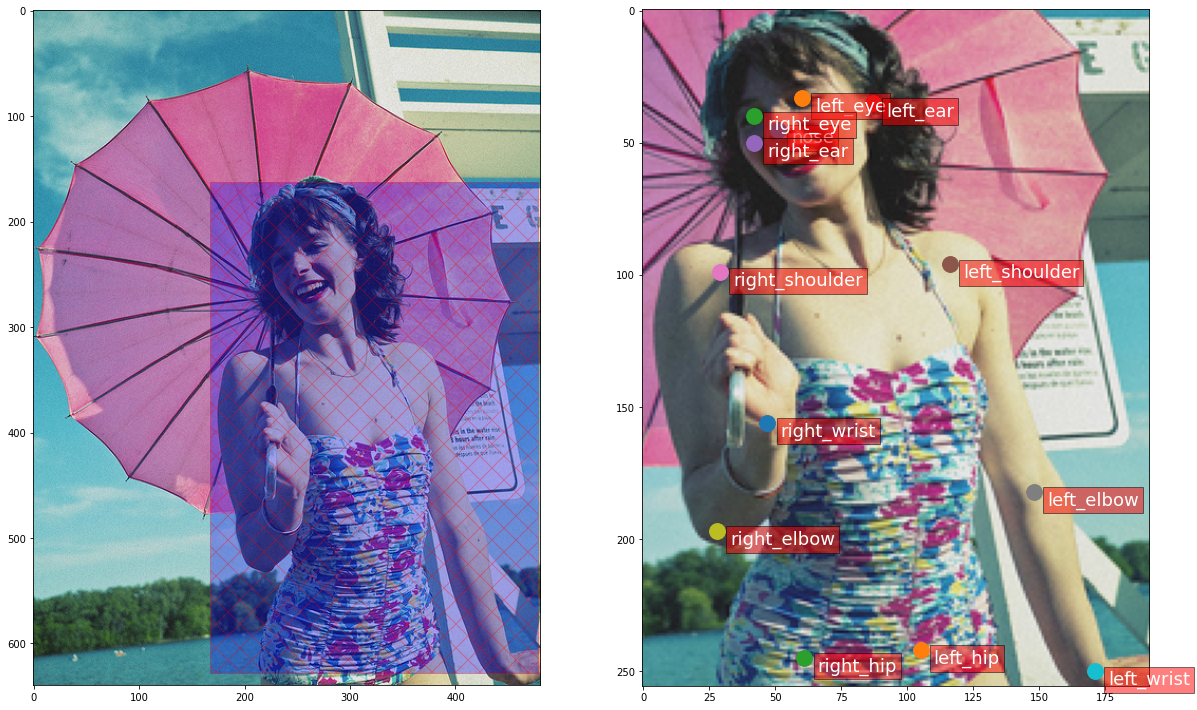

In [39]:
img_id,bbox,is_crowd,keypoints,k_vis = get_sample_att(116259)
og_img = get_img(img_id)
bbox = check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img)
res_img = crop_resize_img(og_img,bbox)
keypoints = rescale_keypoints(keypoints,bbox)
display_images_keypoints(1,og_img,bbox,res_img,keypoints,k_vis)

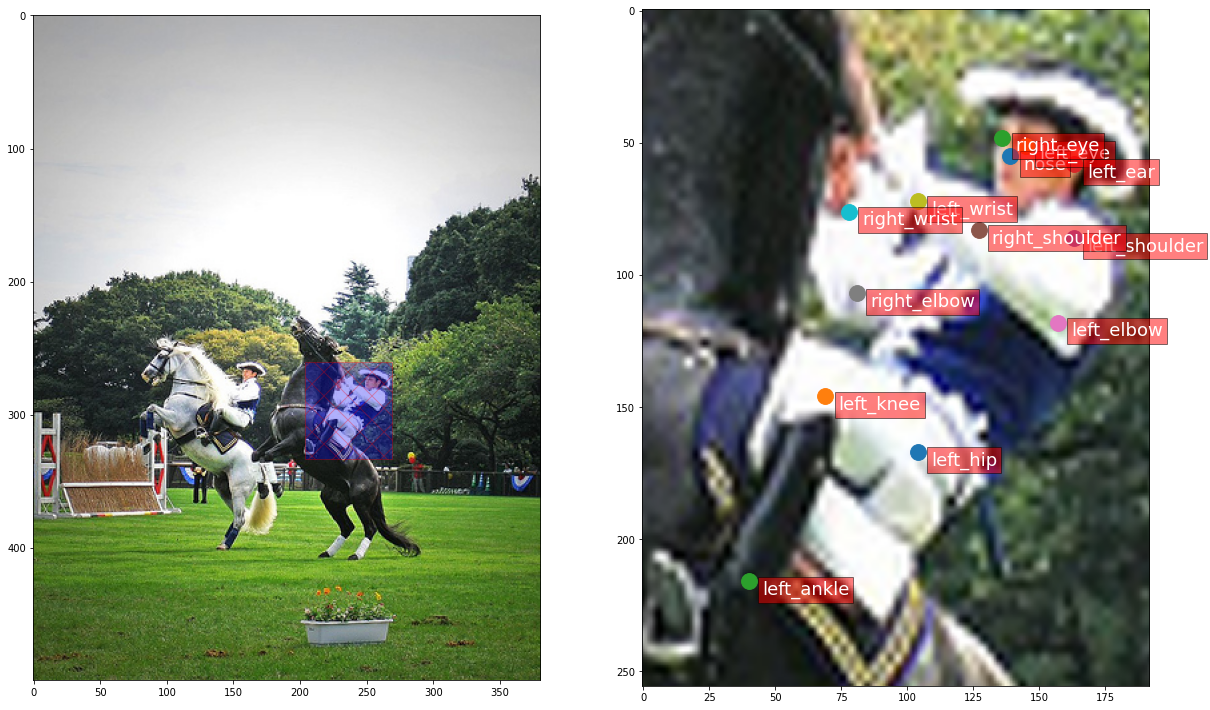

In [47]:
img_id,bbox,is_crowd,keypoints,k_vis = get_sample_att(83433)
og_img = get_img(img_id)
bbox = check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img)
res_img = crop_resize_img(og_img,bbox)
keypoints = rescale_keypoints(keypoints,bbox)
display_images_keypoints(1,og_img,bbox,res_img,keypoints,k_vis)

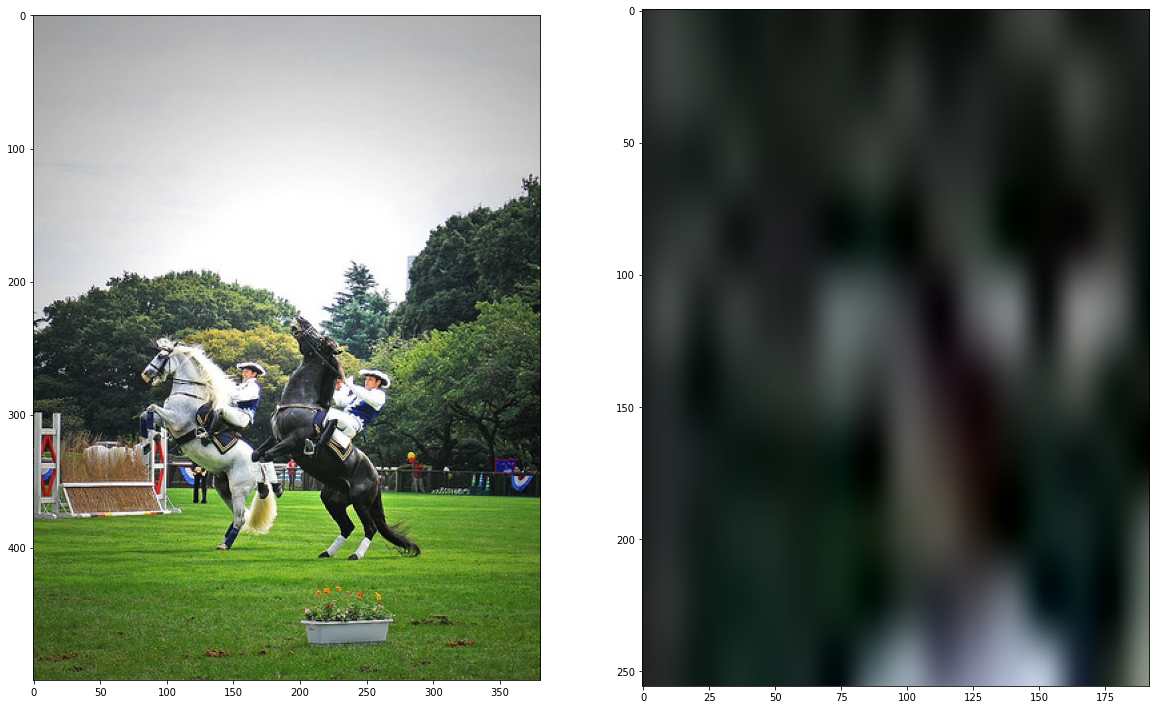

In [48]:
img_id,bbox,is_crowd,keypoints,k_vis = get_sample_att(253694)
og_img = get_img(img_id)
bbox = check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img)
res_img = crop_resize_img(og_img,bbox)
keypoints = rescale_keypoints(keypoints,bbox)
display_images_keypoints(1,og_img,bbox,res_img,keypoints,k_vis)

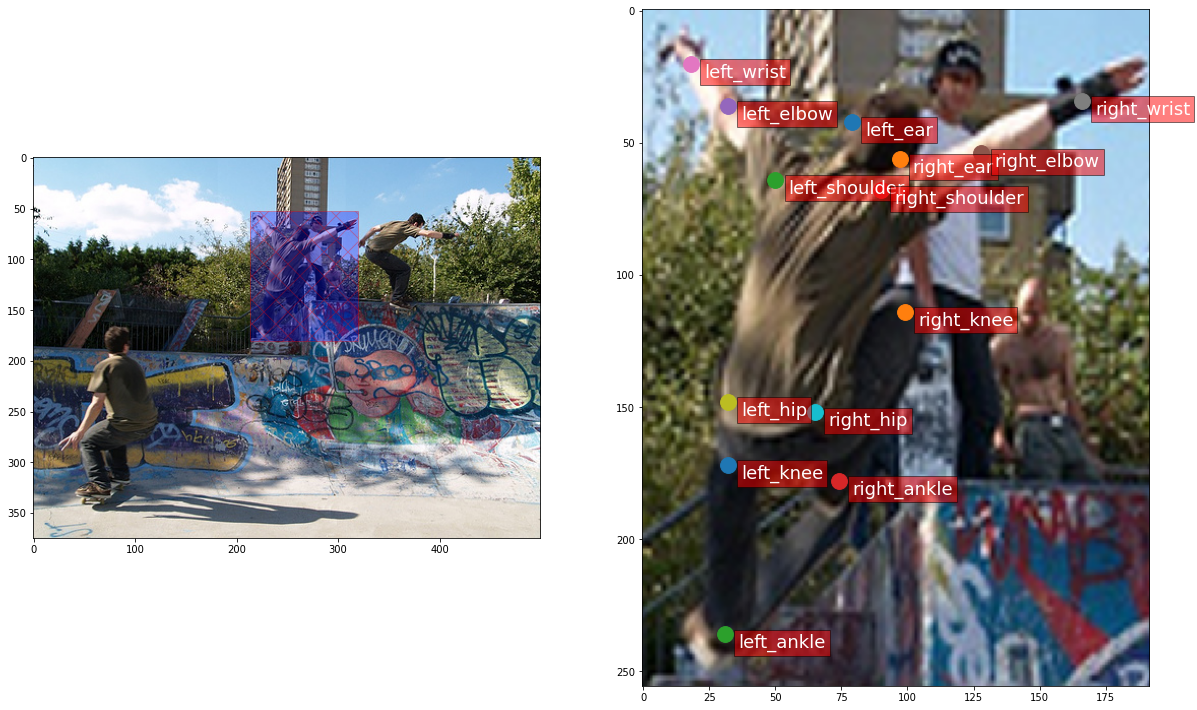

In [51]:
img_id,bbox,is_crowd,keypoints,k_vis = get_sample_att(122909)
og_img = get_img(img_id)
bbox = check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img)
res_img = crop_resize_img(og_img,bbox)
keypoints = rescale_keypoints(keypoints,bbox)
display_images_keypoints(1,og_img,bbox,res_img,keypoints,k_vis)

In [43]:
img_id,bbox,is_crowd,keypoints,k_vis = get_sample_att(116259)
keypoints

array([[250, 244],
       [265, 223],
       [235, 235],
       [309, 227],
       [235, 253],
       [355, 337],
       [215, 342],
       [407, 494],
       [213, 520],
       [445, 617],
       [244, 447],
       [338, 603],
       [267, 608],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0]])

In [40]:
keypoints

array([[ 51,  45],
       [ 60,  33],
       [ 42,  40],
       [ 87,  35],
       [ 42,  50],
       [116,  96],
       [ 29,  99],
       [148, 182],
       [ 28, 197],
       [171, 250],
       [ 47, 156],
       [105, 242],
       [ 61, 245],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0]])

In [44]:
coco_ann['annotations'][116259]['keypoints']

[250,
 244,
 2,
 265,
 223,
 2,
 235,
 235,
 2,
 309,
 227,
 2,
 235,
 253,
 2,
 355,
 337,
 2,
 215,
 342,
 2,
 407,
 494,
 2,
 213,
 520,
 2,
 445,
 617,
 2,
 244,
 447,
 2,
 338,
 603,
 2,
 267,
 608,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

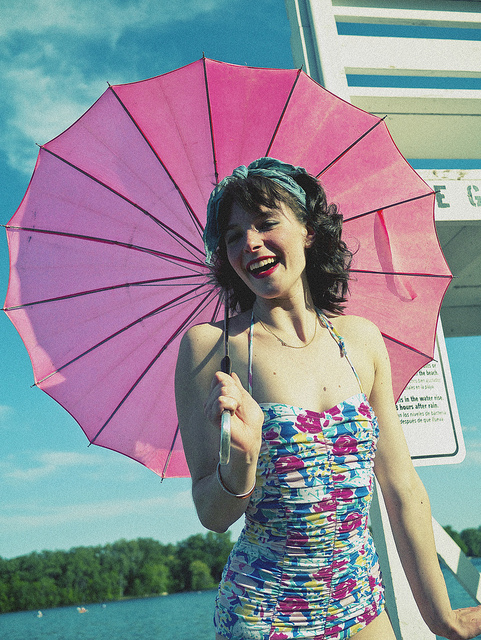

In [30]:
get_img('36')

display_images_keypoints(DRAW_NON_VISIBLE,og_img,bbox,res_img,keypoints,k_vis)

In [49]:
db1[3]

(tensor([[[ 2.1520,  2.1520,  2.1520,  ...,  0.3393,  0.3393,  0.3568],
          [ 2.1520,  2.1694,  2.1694,  ...,  0.3393,  0.3393,  0.3568],
          [ 2.1694,  2.1694,  2.1694,  ...,  0.3393,  0.3393,  0.3568],
          ...,
          [-0.2707, -0.2881, -0.1835,  ..., -0.3927, -0.4101, -0.4973],
          [-0.3753, -0.3055, -0.2184,  ..., -0.3055, -0.3404, -0.4101],
          [-0.4101, -0.2881, -0.2707,  ..., -0.2010, -0.2532, -0.3578]],
 
         [[ 2.4241,  2.4241,  2.4241,  ...,  1.4787,  1.4787,  1.4787],
          [ 2.4241,  2.4241,  2.4241,  ...,  1.4787,  1.4787,  1.4787],
          [ 2.4241,  2.4241,  2.4241,  ...,  1.4787,  1.4787,  1.4962],
          ...,
          [-0.1144, -0.1669, -0.0969,  ..., -0.0619, -0.1144, -0.2545],
          [-0.1669, -0.1669, -0.0794,  ...,  0.0432, -0.0619, -0.1669],
          [-0.1669, -0.1319, -0.1319,  ...,  0.2182,  0.0782, -0.0794]],
 
         [[ 1.4659,  1.4659,  1.4659,  ...,  1.1063,  1.1063,  1.1063],
          [ 1.4659,  1.4659,

In [ ]:
49

In [50]:
for idx, i in enumerate(coco_ann['annotations']):
  if i['image_id'] == 77:
    print(idx)

122909
134343
224241
226815
238548


In [12]:
from glob import glob

t = glob('/home/aiteam/tykim/HybrIK/data/coco/train2017/*.jpg')

In [13]:
t[0]

'/home/aiteam/tykim/HybrIK/data/coco/train2017/000000535141.jpg'

In [ ]:
/home/aiteam/tykim/HybrIK/data/coco/train2017/000000

In [34]:
with open('/home/aiteam/tykim/nia-3d/HybrIK/data/nia/122-1.다중객체3차원표현데이터(실내)/02.라벨링데이터(2D)/20220926/I_M022_T018-T02-00_T000-T00-00_B00019_L.json') as f:
  data = json.load(f)

In [35]:
data.keys()

dict_keys(['info.image.id', 'objects', 'info.created_date', 'info.image.file_format', 'info.image.imsize', 'info.camera.device', 'info.region_name', 'info.images_location', 'info.copyright', 'info.image.width', 'info.image.height', 'info.image.Aspect ratio', 'info.image.resolution', 'info.camera.position', 'info.camera.focal_length', 'info.camera.principal_point', 'info.camera.rotation', 'info.camera.translation', 'info.camera.intrinsic', 'info.camera.extrinsic', 'info.actor.id', 'info.actor.gender', 'info.actor.age', 'info.actor.height', 'info.actor.weight', 'info.actor.height_of_shoes', 'info.actor.mesh_path', 'info.actor.pointcloud_path', 'info.actor.texture_path', 'info.object1.id', 'info.object1.name', 'info.object1.size', 'info.object1.mesh_path', 'info.object1.pointcloud_path', 'info.object1.texture_path', 'info.object2.id', 'info.object2.name', 'info.object2.size', 'info.object2.mesh_path', 'info.object2.pointcloud_path', 'info.object2.texture_path', 'info.actor.first_category'

In [36]:
len(data['objects'])

9

In [37]:
for i in data['objects'][2]['annotation.human.keypoint.2d']:
  print(i['name'])

pelvis
left hip
left knee
left ankle
left bigtoe
left littletoe
right hip
right_knee
right ankle
right bigtoe
right littletoe
waist
chest
neck
left shoulder
left elbow
left wrist
left index finger
left pinky
right shoulder
right elbow
right wrist
right index finger
right pinky
nose
left eye
left ear
right eye
right ear


In [ ]:
annotation.human.keypoint.2d